<a href="https://colab.research.google.com/github/lorenzopalaia/Progetto-Lab-IA/blob/main/Progetto_Lab_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


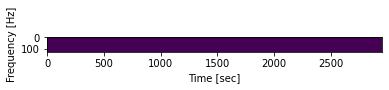

In [10]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('data/test15sMono.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()